# Homework 1

In [1]:
# %pip install rawpy

In [2]:
import rawpy
import numpy as np
import imageio
from scipy.ndimage import correlate

In [3]:
# set input path
path_in = 'L1004220.DNG'
# path_in = 'L1004235.DNG'
# path_in = 'L1004432.DNG'

In [4]:
# filename for JPEG output
path_out  = path_in.split('.')[0] + '.jpg'
path_out

'L1004220.jpg'

In [5]:
# read 16-bit integer data from RAW file into raw_image array
with rawpy.imread(path_in) as raw:
    raw_image = raw.raw_image.copy()

Convert the raw image data to a 32-bit floating pint in [0 1] range.

In [6]:
raw_float = raw_image.astype('float32') / np.iinfo(raw_image.dtype).max
h, w = raw_float.shape

Demosaic

In [7]:
# create the filter kernels needed for bayer demosaicing
maskR = np.zeros_like(raw_float)
maskG = np.zeros_like(raw_float)
maskB = np.zeros_like(raw_float)

maskR[0::2, 0::2] = 1 # even rows, even columns
maskG[0::2, 1::2] = 1 # even rows, odd columns
maskG[1::2, 0::2] = 1 # odd rows, even columns
maskB[1::2, 1::2] = 1 # odd rows, odd columns

rawR = raw_float * maskR
rawG = raw_float * maskG
rawB = raw_float * maskB

In [8]:
# apply filter kernels to the raw image
kernel = np.array([[1, 2, 1],
                     [2, 4, 2],
                     [1, 2, 1]], dtype=np.float32) / 16.0

# convolve each channel
R = correlate(rawR, kernel, mode='mirror')
G = correlate(rawG, kernel, mode='mirror')
B = correlate(rawB, kernel, mode='mirror')

# stacking channels into single arr
rgb = np.stack((R, G, B), axis=-1)

White balance

In [9]:
means = rgb.reshape(-1, 3).mean(axis=0)
scale_factors = 0.25 / means
wb_rgb = rgb * scale_factors

Gamma curve

In [10]:
gamma_rgb = np.power(wb_rgb, 0.55)

Clip and quantize

In [11]:
clipped_rgb = np.clip(gamma_rgb, 0, 1)
# convert to 8-bit integer
rgb_8bit = (clipped_rgb * 255).astype(np.uint8)

Compress

In [12]:
imageio.imwrite(path_out, rgb_8bit)
print(f'Wrote {path_out}')

Wrote L1004220.jpg


Comparison Code

/var/folders/q8/mqm68gfx7pjfpqftf7y_v6140000gn/T/ipykernel_12821/4060918931.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gt   = imageio.imread(output_image).astype(np.float32)/255.0
/var/folders/q8/mqm68gfx7pjfpqftf7y_v6140000gn/T/ipykernel_12821/4060918931.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mine = imageio.imread(path_out).astype(np.float32)/255.0


MSE:  0.000174
PSNR: 37.60 dB
SSIM: 0.9808


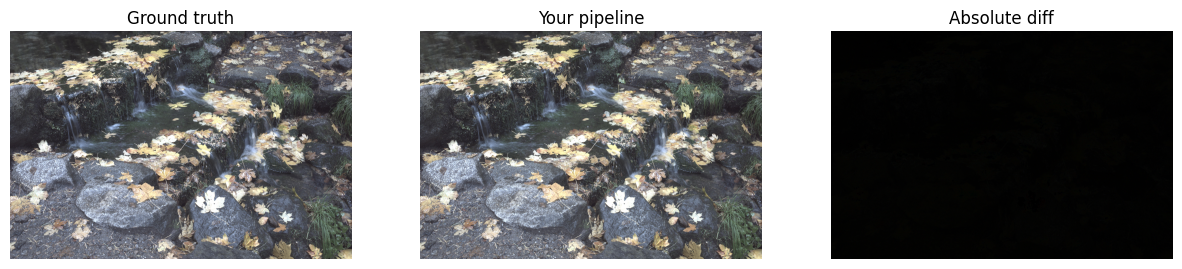

In [13]:
import imageio
import numpy as np
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt

# load both images as floats in [0,1]
output_image = "output/" + path_out.split('/')[-1]
gt   = imageio.imread(output_image).astype(np.float32)/255.0
mine = imageio.imread(path_out).astype(np.float32)/255.0

# ensure same shape
assert gt.shape == mine.shape

# compute metrics
mse  = mean_squared_error(gt, mine)
psnr = peak_signal_noise_ratio(gt, mine, data_range=1.0)
ssim_val = structural_similarity(
    gt,
    mine,
    channel_axis=-1,
    win_size=7,     
    data_range=1.0 
)

print(f"MSE:  {mse:.6f}")
print(f"PSNR: {psnr:.2f} dB")
print(f"SSIM: {ssim_val:.4f}")

# show side‑by‑side + absolute difference
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].imshow(gt);   axes[0].set_title('Ground truth'); axes[0].axis('off')
axes[1].imshow(mine); axes[1].set_title('Your pipeline'); axes[1].axis('off')
axes[2].imshow(np.abs(gt-mine)); axes[2].set_title('Absolute diff'); axes[2].axis('off')
plt.show()